![image-alt-text](https://sedona.apache.org/1.5.0/image/sedona-ecosystem.png)

##### Required python packages to run spatial sql queries in Spark SQL

In [ ]:
!pip install apache-sedona==1.5.0 keplergl pydeck

In [2]:
from pyspark.sql import SparkSession
from sedona.spark import *

StatementMeta(, 7abe8a70-1122-4db6-aa4c-abcbdcc7a015, 6, Finished, Available, Finished)

In [3]:
sedona = SedonaContext.create(spark)

StatementMeta(, 7abe8a70-1122-4db6-aa4c-abcbdcc7a015, 7, Finished, Available, Finished)

In [4]:
spark.sql("""SELECT ST_GeomFromText("POLYGON ((0 0, 150 0, 150 150, 0 150, 0 0))") AS geom""").printSchema()

StatementMeta(, 7abe8a70-1122-4db6-aa4c-abcbdcc7a015, 8, Finished, Available, Finished)

root
 |-- geom: geometry (nullable = true)



In [5]:
display(spark.sql("""SELECT ST_GeomFromText("POLYGON ((0 0, 150 0, 150 150, 0 150, 0 0))") AS geom"""))

StatementMeta(, 7abe8a70-1122-4db6-aa4c-abcbdcc7a015, 9, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 5fbfe8e4-24eb-4dbd-a935-4a7af899d205)

In [6]:
spark.sql("""SELECT ST_GeomFromText("POLYGON ((0 0, 150 0, 150 150, 0 150, 0 0))") AS geom""").schema

StatementMeta(, 7abe8a70-1122-4db6-aa4c-abcbdcc7a015, 10, Finished, Available, Finished)

StructType([StructField('geom', GeometryType(), True)])

In [7]:
display(spark.sql("""SELECT ST_AsGeoJSON(ST_GeomFromText("POLYGON ((0 0, 150 0, 150 150, 0 150, 0 0))")) AS geojson"""))

StatementMeta(, 7abe8a70-1122-4db6-aa4c-abcbdcc7a015, 11, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 8d45868d-423b-4551-85f5-ce94b8fe02d0)

#### Let's create two datasets:

Cities - represented by points (latitude, longitude)

Regions - represented by polygons

###### WKT stands for Well-Known Text — it's a simple text format for representing geometric shapes like points, lines, and polygons.

It's part of the OGC (Open Geospatial Consortium) standard, and it's used widely in GIS systems, databases (like PostGIS), and libraries such as Apache Sedona, Shapely, or GeoPandas.

In [8]:
from pyspark.sql import Row

# Cities (name, coordinates)
city_data = [
    Row(name="CityA", wkt="POINT(1 1)"),
    Row(name="CityB", wkt="POINT(3 3)"),
    Row(name="CityC", wkt="POINT(8 8)")
]

# Regions (region name, polygon)
region_data = [
    Row(region="Region1", wkt="POLYGON((0 0, 0 5, 5 5, 5 0, 0 0))"),
    Row(region="Region2", wkt="POLYGON((6 6, 6 10, 10 10, 10 6, 6 6))")
]

cities_df = spark.createDataFrame(city_data)
regions_df = spark.createDataFrame(region_data)

cities_df.createOrReplaceTempView("cities_raw")
regions_df.createOrReplaceTempView("regions_raw")

StatementMeta(, 7abe8a70-1122-4db6-aa4c-abcbdcc7a015, 12, Finished, Available, Finished)

#### Register as Geometries
Convert the WKT strings into actual geometry objects using Sedona's ST_GeomFromText.

###### ST_GeomFromText (short for Spatial Type Geometry From Text)
is a Sedona SQL function that converts a WKT (Well-Known Text) string into an actual geometry object that Sedona can understand and use for spatial analysis.

In [9]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW cities AS
SELECT name, ST_GeomFromText(wkt, 4326) AS geom FROM cities_raw
""")

spark.sql("""
CREATE OR REPLACE TEMP VIEW regions AS
SELECT region, ST_GeomFromText(wkt, 4326) AS geom FROM regions_raw
""")


StatementMeta(, 7abe8a70-1122-4db6-aa4c-abcbdcc7a015, 13, Finished, Available, Finished)

DataFrame[]

#### Perform a Spatial Join

Now we'll find which cities fall inside which regions using ST_Contains.

##### Explanation:

CityA (1,1) and CityB (3,3) are inside Region1’s polygon (0–5 boundary).

CityC (8,8) is inside Region2’s polygon (6–10 boundary).

Sedona handles the geometry operations under the hood.

In [10]:
result_df = spark.sql("""
SELECT
    r.region,
    c.name AS city
FROM regions r, cities c
WHERE ST_Contains(r.geom, c.geom)
""")

result_df.show(truncate=False)


StatementMeta(, 7abe8a70-1122-4db6-aa4c-abcbdcc7a015, 14, Finished, Available, Finished)

+-------+-----+
|region |city |
+-------+-----+
|Region1|CityA|
|Region1|CityB|
|Region2|CityC|
+-------+-----+



##### Goal

We'll visualize:

🟩 Two regions (polygons)

🔵 Three cities (points)

And show which city lies inside which region

In [ ]:
!pip install geopandas shapely matplotlib

In [12]:
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# Cities (points)
cities = gpd.GeoDataFrame({
    "name": ["CityA", "CityB", "CityC"],
    "geometry": [
        wkt.loads("POINT(1 1)"),
        wkt.loads("POINT(3 3)"),
        wkt.loads("POINT(8 8)")
    ]
})

# Regions (polygons)
regions = gpd.GeoDataFrame({
    "region": ["Region1", "Region2"],
    "geometry": [
        wkt.loads("POLYGON((0 0, 0 5, 5 5, 5 0, 0 0))"),
        wkt.loads("POLYGON((6 6, 6 10, 10 10, 10 6, 6 6))")
    ]
})

StatementMeta(, 7abe8a70-1122-4db6-aa4c-abcbdcc7a015, 16, Finished, Available, Finished)

StatementMeta(, 7abe8a70-1122-4db6-aa4c-abcbdcc7a015, 17, Finished, Available, Finished)

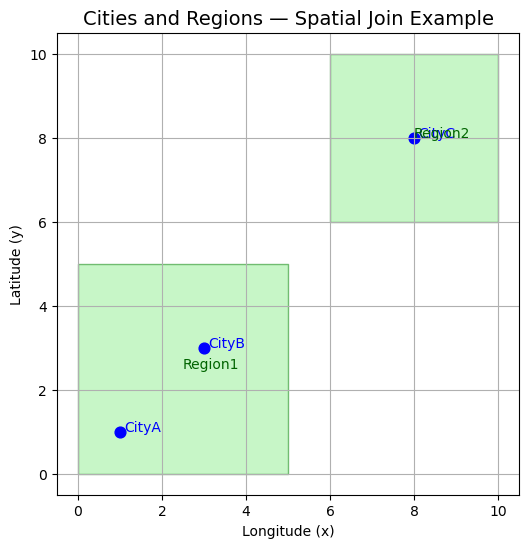

In [13]:
fig, ax = plt.subplots(figsize=(6,6))

# Plot regions (green polygons)
regions.plot(ax=ax, color='lightgreen', edgecolor='green', alpha=0.5)

# Plot cities (blue dots)
cities.plot(ax=ax, color='blue', markersize=60)

# Add labels
for x, y, label in zip(cities.geometry.x, cities.geometry.y, cities["name"]):
    ax.text(x + 0.1, y, label, fontsize=10, color='blue')

for poly, label in zip(regions.geometry.centroid, regions["region"]):
    ax.text(poly.x, poly.y, label, fontsize=10, color='darkgreen')

ax.set_title("Cities and Regions — Spatial Join Example", fontsize=14)
ax.set_xlabel("Longitude (x)")
ax.set_ylabel("Latitude (y)")
plt.grid(True)
plt.show()